# Set up

In [1]:
import torch
import gpytorch
import pandas as pd
import numpy as np
import tqdm as tqdm
from linear_operator import settings

import pyro
import math
import pickle
import time
from joblib import Parallel, delayed

from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import pyro.distributions as dist
from pyro.infer import MCMC, NUTS
import arviz as az
import seaborn as sns

import os

from torch.utils.data import TensorDataset, DataLoader
import itertools

import pyro
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.optim import ClippedAdam

In [2]:
import GP_functions.Loss_function as Loss_function
import GP_functions.bound as bound
import GP_functions.Estimation as Estimation
import GP_functions.Training as Training
import GP_functions.Prediction as Prediction
import GP_functions.NN_models as NN_models
import GP_functions.Tools as Tools
import GP_functions.FeatureE as FeatureE

# Data

In [3]:
X_train = pd.read_csv('Data/X_train.csv', header=None, delimiter=',').values
X_test = pd.read_csv('Data/X_test.csv', header=None, delimiter=',').values

Y_train_21 = pd.read_csv('Data/Y_train_std_21.csv', header=None, delimiter=',').values
Y_test_21 = pd.read_csv('Data/Y_test_std_21.csv', header=None, delimiter=',').values

Y_train = pd.read_csv('Data/Y_train_std.csv', header=None, delimiter=',').values
Y_test = pd.read_csv('Data/Y_test_std.csv', header=None, delimiter=',').values


train_x = torch.tensor(X_train, dtype=torch.float32)
test_x = torch.tensor(X_test, dtype=torch.float32)

train_y_21 = torch.tensor(Y_train_21, dtype=torch.float32)
test_y_21 = torch.tensor(Y_test_21, dtype=torch.float32)

# train_y = torch.tensor(Y_train, dtype=torch.float32)
# test_y = torch.tensor(Y_test, dtype=torch.float32)


# torch.set_default_dtype(torch.float32)

# Model

In [ ]:
NN_4 = Training.train_DNN_MSE(NN_models.NN_4,
                              train_x, train_y_21,
                              num_iterations= 50000,
                              device= 'cuda',
                              show_progress = True,
                              weight_decay = 0,
                              val_x=test_x,
                              val_y=test_y_21,
                              early_stopping = True,
                              patience = 1000,
                              val_check_interval = 100)

In [ ]:
NN_4_cpu = NN_4.to('cpu')

In [ ]:
Device = 'cpu'

row_idx = 10
input_point = test_y_21[row_idx, :]

local_train_x, local_train_y = Tools.find_k_nearest_neighbors_CPU(input_point, train_x, train_y_21, k=100)

preds_tmp = Prediction.preds_for_DNN(NN_4_cpu, test_x[row_idx,:].unsqueeze(0).to(Device)
    ).cpu().detach().numpy()


In [ ]:
preds_tmp

In [ ]:
bounds = bound.get_bounds(local_train_x)

estimated_params_tmp, Loss = Estimation.multi_start_estimation_DModel(NN_4_cpu, row_idx, test_y_21, bounds,
                                                                   Estimation.estimate_params_for_NN_Adam, num_starts=4, num_iterations=1000, lr=0.01,
                                                                   patience=10, attraction_threshold=0.1, repulsion_strength=0.1, device=Device)

In [ ]:
Loss

In [ ]:
estimated_params_tmp

In [4]:
BNN_5_model, BNN_5_guide = Training.train_BNN_minibatch(NN_models.BNN_5,
    train_x,
    train_y_21,
    num_iterations=5,
    batch_size=256,
    device='cuda',
    show_progress=True,
    val_x=test_x,
    val_y=test_y_21,
    early_stopping=True,
    patience=1000,
    val_check_interval=100)

SVI training: 100%|██████████| 5/5 [00:01<00:00,  3.31it/s]


In [4]:
BNN_WideDrop_model, BNN_WideDrop_guide = Training.train_BNN_minibatch(NN_models.BNN_WideDrop,
    train_x,
    train_y_21,
    num_iterations=50000,
    batch_size=256,
    device='cuda',
    show_progress=True,
    val_x=test_x,
    val_y=test_y_21,
    early_stopping=True,
    patience=1000,
    val_check_interval=100)

/home/pgrad1/2633042r/miniconda3/envs/GPyTorch/lib/python3.8/site-packages/torch/cuda/__init__.py:628: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
SVI training: 100%|██████████| 50000/50000 [41:55<00:00, 19.87it/s] 


In [7]:
def evaluate_mse(model, x, y):
    model.eval()
    x = x.to(device)
    y = y.to(device)
    with torch.no_grad():
        # model(x) returns a Distribution when y=None
        pred_dist = model(x)
        preds = pred_dist.mean
    # MSE over all outputs
    return torch.mean((preds - y) ** 2).item()

device = 'cuda'

BNN_WideDrop_model.to(device)
BNN_WideDrop_guide.to(device)
mse = evaluate_mse(BNN_WideDrop_model, test_x, test_y_21)
print(f"MSE on test set: {mse:.4f}")

MSE on test set: 47563.5898


In [ ]:
BNN_ARD_model, BNN_ARD_guide = Training.train_BNN_minibatch(NN_models.BNN_ARD,
    train_x,
    train_y_21,
    num_iterations=50000,
    batch_size=256,
    device='cuda',
    show_progress=True,
    val_x=test_x,
    val_y=test_y_21,
    early_stopping=True,
    patience=1000,
    val_check_interval=100)

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model_path = "best_model_BNN_5.pt"
guide_path = "best_guide_BNN_5.pt"

BNN_5_model.load_state_dict(torch.load(model_path, map_location=device))
BNN_5_guide.load_state_dict(torch.load(guide_path, map_location=device))

with open("best_param_store_BNN_5.pkl", "rb") as f:
    raw_state = pickle.load(f)


def to_device(obj):
    if torch.is_tensor(obj):
        return obj.to(device)
    elif isinstance(obj, dict):
        return {k: to_device(v) for k, v in obj.items()}
    elif isinstance(obj, (list, tuple)):
        return type(obj)(to_device(v) for v in obj)
    else:
        return obj

param_state = to_device(raw_state)

pyro.get_param_store().set_state(param_state)

In [6]:
BNN_5_model.eval()
BNN_5_guide.eval()

AutoDiagonalNormal()

# Paramater inference

In [7]:
row_idx = 0
input_point = test_y_21[row_idx, :]

local_train_x, local_train_y = Tools.find_k_nearest_neighbors_GPU(input_point, train_x, train_y_21, k=100)


In [8]:
predictive = Predictive(
    BNN_5_model,
    guide=BNN_5_guide,
    return_sites=["obs"],
    num_samples=1000
)

In [26]:
predictive(test_x[row_idx,:].unsqueeze(0).to(device))["obs"].squeeze(1)

tensor([[-0.8607, -0.6828,  0.1543,  ..., -0.3839,  0.2299, -0.0108],
        [-0.2754,  0.0490,  3.5848,  ...,  2.0895, -0.6661, -0.0281],
        [ 2.0167,  0.1189,  1.1743,  ...,  1.9346, -1.7065, -1.2943],
        ...,
        [ 0.2024,  0.4489,  1.8899,  ..., -1.1173, -0.4443,  0.8977],
        [ 0.9581, -2.8945,  1.5037,  ...,  2.1460, -3.4034, -0.8023],
        [-1.5419, -1.5373,  1.8356,  ...,  1.3894,  1.7247,  2.6266]],
       device='cuda:0')

In [9]:
y_samples = predictive(test_x[row_idx,:].unsqueeze(0).to(device))["obs"].squeeze(1)

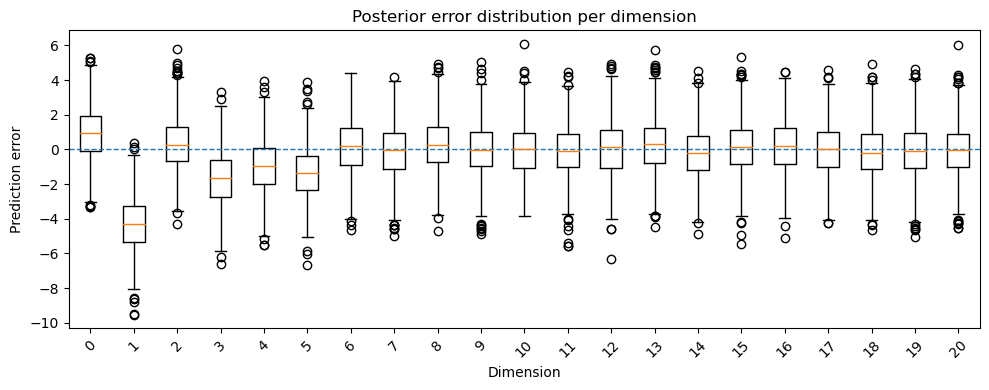

In [36]:
errors = y_samples - input_point.to(device)


fig, ax = plt.subplots(figsize=(10, 4))
ax.boxplot(errors.cpu().T, vert=True, showfliers=True)
ax.axhline(0, ls='--', lw=1)
ax.set_xlabel("Dimension")
ax.set_ylabel("Prediction error")
ax.set_title("Posterior error distribution per dimension")
ax.set_xticks(np.arange(1, 22))
ax.set_xticklabels([str(i) for i in range(21)], rotation=45)
plt.tight_layout()
plt.show()

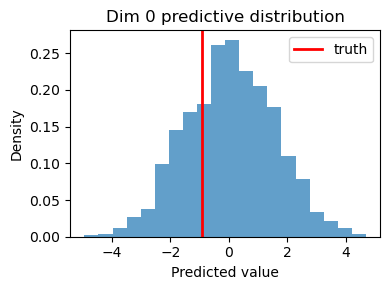

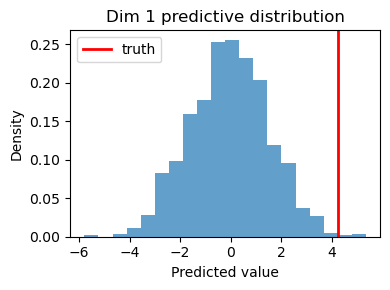

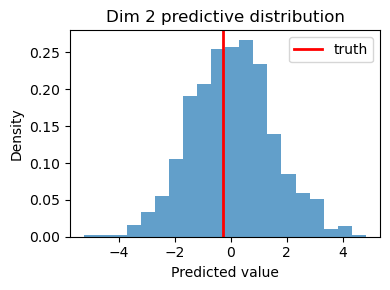

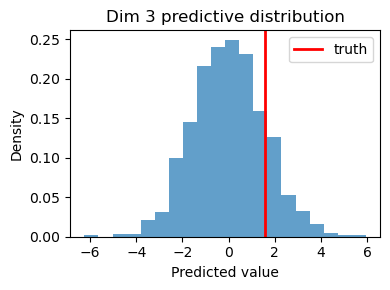

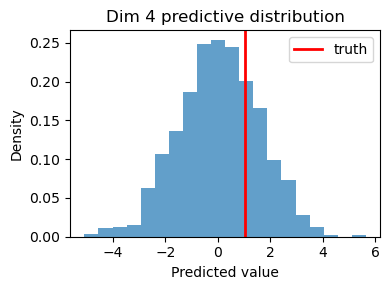

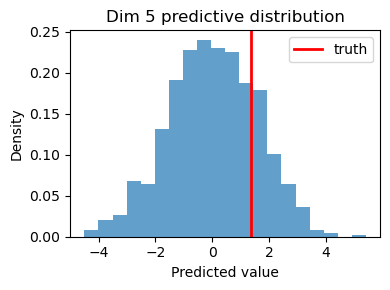

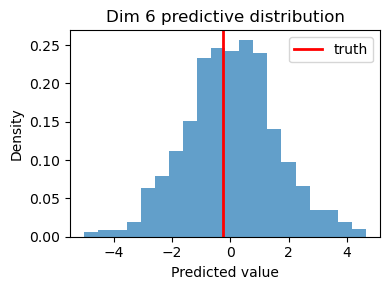

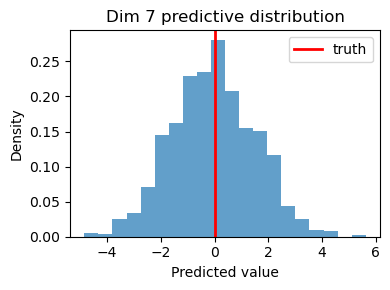

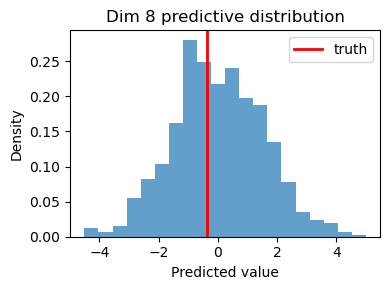

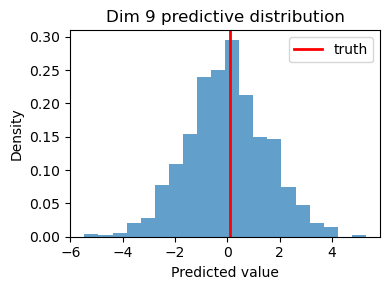

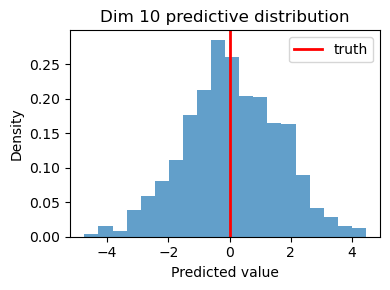

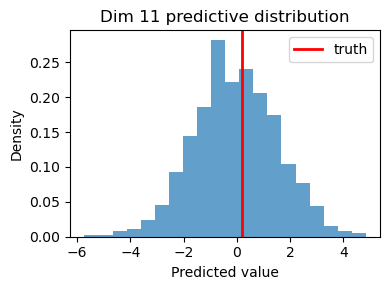

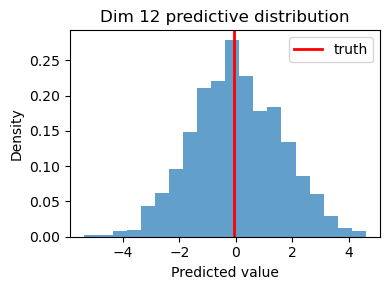

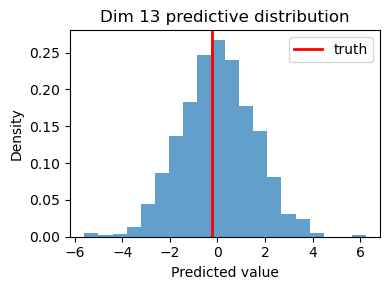

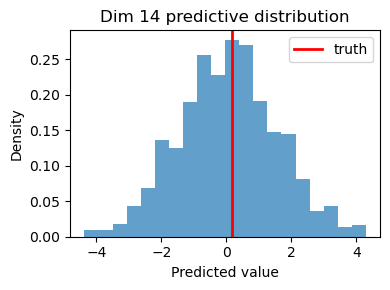

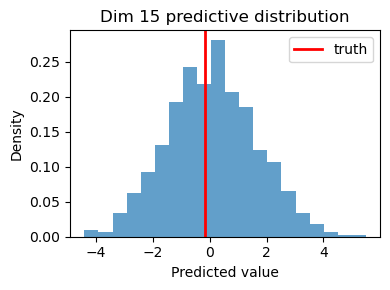

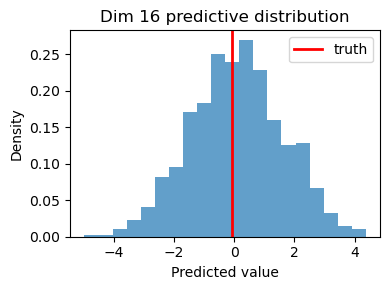

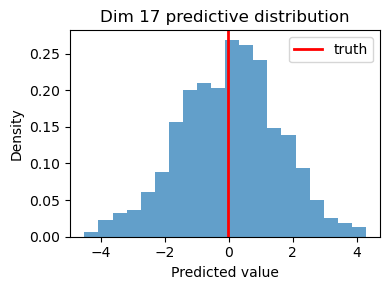

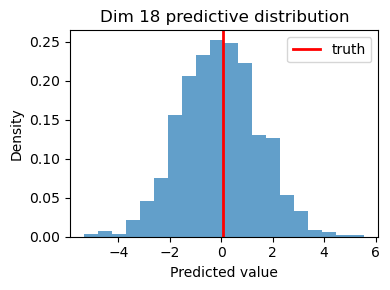

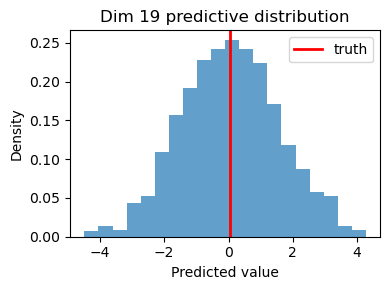

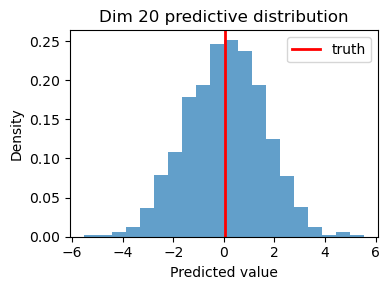

In [10]:
import matplotlib.pyplot as plt

for d in range(21):
    plt.figure(figsize=(4, 3))
    plt.hist(y_samples[:, d].cpu(), bins=20, density=True, alpha=0.7)
    plt.axvline(input_point.to(device)[d].item(), color="r", lw=2, label="truth")
    plt.title(f"Dim {d} predictive distribution")
    plt.xlabel("Predicted value");  plt.ylabel("Density")
    plt.legend();  plt.tight_layout();  plt.show()

In [7]:
predictive = Predictive(BNN_5_model, guide=BNN_5_guide, 
           return_sites=["obs"],
           num_samples=100)

In [10]:
samples = predictive(test_x[row_idx,:].unsqueeze(0).to(device))["obs"] 

In [11]:
samples.mean(0)  

tensor([[ 5.3624e-02, -1.3356e-04, -1.0938e-01,  1.7315e-01,  5.4121e-02,
          3.5498e-01, -4.8893e-02, -1.0174e-01, -1.0097e-01,  6.0037e-02,
         -5.7643e-02, -1.2319e-02,  6.5934e-02, -1.4294e-01, -1.6421e-01,
          1.2462e-01,  5.3079e-02,  1.2679e-01, -9.9078e-02,  1.1324e-01,
         -1.0662e-01]], device='cuda:0')

In [12]:
input_point

tensor([-0.9226,  4.2240, -0.2954,  1.5937,  1.0363,  1.3768, -0.2562,  0.0340,
        -0.3592,  0.1005,  0.0101,  0.1750, -0.0758, -0.2362,  0.1707, -0.1471,
        -0.0780, -0.0288,  0.0638,  0.0508,  0.0267])

In [9]:
BNN_5_model.eval()
with torch.no_grad():
    dist_pred = BNN_5_model(test_x[row_idx,:].unsqueeze(0).to(device))

dist_pred.mean

tensor([[-1.2868e-01, -1.9264e-01, -4.0427e-03, -5.7380e-02,  1.8914e-02,
          1.2350e-01,  2.4774e-01, -5.6970e-02, -2.3492e-02,  7.8554e-02,
          8.2558e-02, -2.1066e-03,  2.9587e-02,  9.5620e-02,  1.2337e-01,
          1.4462e-01, -9.6105e-02, -1.2116e-01,  2.2176e-02, -1.9958e-04,
          1.7139e-01]], device='cuda:0')

## Point

## MCMC